# ADP 실기 28회 머신러닝 
## 학생 결석일수 예측 : 차원축소, 랜포, 인공신경망, LGBM, 보팅
```
- 성별(sex) 바이너리 : ‘F’ - 여성 또는 ‘M’ - 남성
- 나이(age) 숫자: 15 - 22
- 부모님동거여부 (Pstatus) 바이너리: T: 동거 또는 ‘A’: 별거
- 엄마학력(Medu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육
- 아빠학력(Fedu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육
- 주보호자(guardian) 명목형 : ‘어머니’, ‘아버지’ 또는 ‘기타’
- 등하교시간(traveltime) 숫자 : 1 : 15분이하, 2 : 15 ~ 30분, 3 : 30분 ~ 1시간, 4 : 1시간 이상
- 학습시간(studytime) 숫자 : 1 : 2시간이하, 2 : 2~5시간, 3 : 5~10시간, 4 : 10시간이상
- 학고횟수(failures) 숫자 : 1, 2, 3 else 4
- 자유시간(freetime) 숫자 : 1(매우 낮음), 2, 3, 4, 5(매우 높음)
- 가족관계(famrel) 숫자 : 1(매우 나쁨), 2, 3, 4, 5(우수)
```

- 1-1) 데이터 EDA & 차원축소가 필요한지?
- 1-2) 1-1에서 찾은 문제 파악후 처리하기
- 1-3) 과적합 문제가 있다고 가정하고 해결하는 방법 2가지 이상 제시/실행/결과

</br>

- 2-1) 랜덤포레스트, 인공신경망(neuralnetwork), LightGBM 모델링 수행 후 f1-score 비교
- 2-2) Soft-voting, Hard-voting 수행 후 f1-score 비교
- 2-3) 5가지 방법 중 최적의 방법 선택 및 이유 설명
- 2-4) 만든 모델을 학교 정보시스템에서 활용하려면 어떻게 해야하는지 적고 설명

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메세지 숨기기
import warnings
warnings.filterwarnings("ignore")

## 1-1) 데이터 EDA & 차원축소가 필요한지?

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,F,18.0,A,4,4,mother,2,2.0,0,4,3.0,6
1,F,17.0,T,1,1,father,2,1.0,0,5,3.0,4
2,F,15.0,T,1,1,mother,2,1.0,3,4,3.0,10
3,F,15.0,T,2,4,mother,3,1.0,0,3,2.0,2
4,F,NaN,T,3,3,father,2,1.0,0,4,3.0,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         395 non-null    object 
 1   age         392 non-null    float64
 2   Pstatus     395 non-null    object 
 3   Fedu        395 non-null    int64  
 4   Medu        395 non-null    int64  
 5   guardian    395 non-null    object 
 6   studytime   395 non-null    int64  
 7   traveltime  392 non-null    float64
 8   failures    395 non-null    int64  
 9   famrel      395 non-null    int64  
 10  freetime    390 non-null    float64
 11  absences    395 non-null    int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.2+ KB


#### 칼럼의 특성을 살펴봤을 때 sex(성별), Pstatus(부모님 동거여부), guardian(주보호자)가 범주형 변수임을 확인할 수 있다.
#### 모델링을 위해 추후 인코딩을 고려해볼 수 있다.

In [4]:
df.describe()

,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,absences
count,392.000000,395.000000,395.000000,395.000000,392.000000,395.000000,395.000000,390.000000,395.000000
mean,16.698980,2.521519,2.749367,2.035443,1.446429,0.334177,3.944304,3.233333,5.708861
std,1.279865,1.088201,1.094735,0.839240,0.695022,0.743651,0.896659,1.000985,8.003096
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,0.000000
50%,17.000000,2.000000,3.000000,2.000000,1.000000,0.000000,4.000000,3.000000,4.000000
75%,18.000000,3.000000,4.000000,2.000000,2.000000,0.000000,5.000000,4.000000,8.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,75.000000


#### Age 변수의 경우, 기초통계량 결과를 봤을 때 큰 이상이 없어보인다. '학생'의 데이터임을 감안했을 때에도 특별한 이상이 없다고 판단했다.

In [5]:
df.isnull().sum() # 실제 28회 후기에는 결측치가 존재하지 않았다고 함

sex           0
age           3
Pstatus       0
Fedu          0
Medu          0
guardian      0
studytime     0
traveltime    3
failures      0
famrel        0
freetime      5
absences      0
dtype: int64

#### 결측치 확인 결과 age 변수, traveltime, freetime 변수에 각각 3, 3, 5개의 결측치가 존재함을 알 수 있었다.

In [6]:
df["absences"].value_counts()

0     115
2      65
4      53
6      31
8      22
10     17
14     12
12     12
3       8
16      7
7       7
5       5
18      5
20      4
11      3
9       3
13      3
15      3
22      3
1       3
38      1
30      1
40      1
23      1
19      1
28      1
75      1
21      1
24      1
56      1
26      1
54      1
25      1
17      1
Name: absences, dtype: int64

In [7]:
# 시험 상황에 비슷하게 값 변형 (임의)
# 실제 28회 후기에는 target 값이 0~4 (5개)

# 랜덤 시드 설정
np.random.seed(42)

# 변경할 숫자 범위 지정
new_values = list(range(5))

# 0~4가 아닌 다른 숫자들에 대해 임의적으로 매핑
other_values = df.loc[~df["absences"].isin(new_values), "absences"].unique()
mapping_dict = {value: np.random.choice(new_values) for value in other_values}

# absences 열에 매핑 적용하여 값 변경
df["absences"] = df["absences"].replace(mapping_dict)

print(df["absences"].value_counts())

0    124
4     99
2     92
3     47
1     33
Name: absences, dtype: int64


### 수치형 변수 분포 시각화

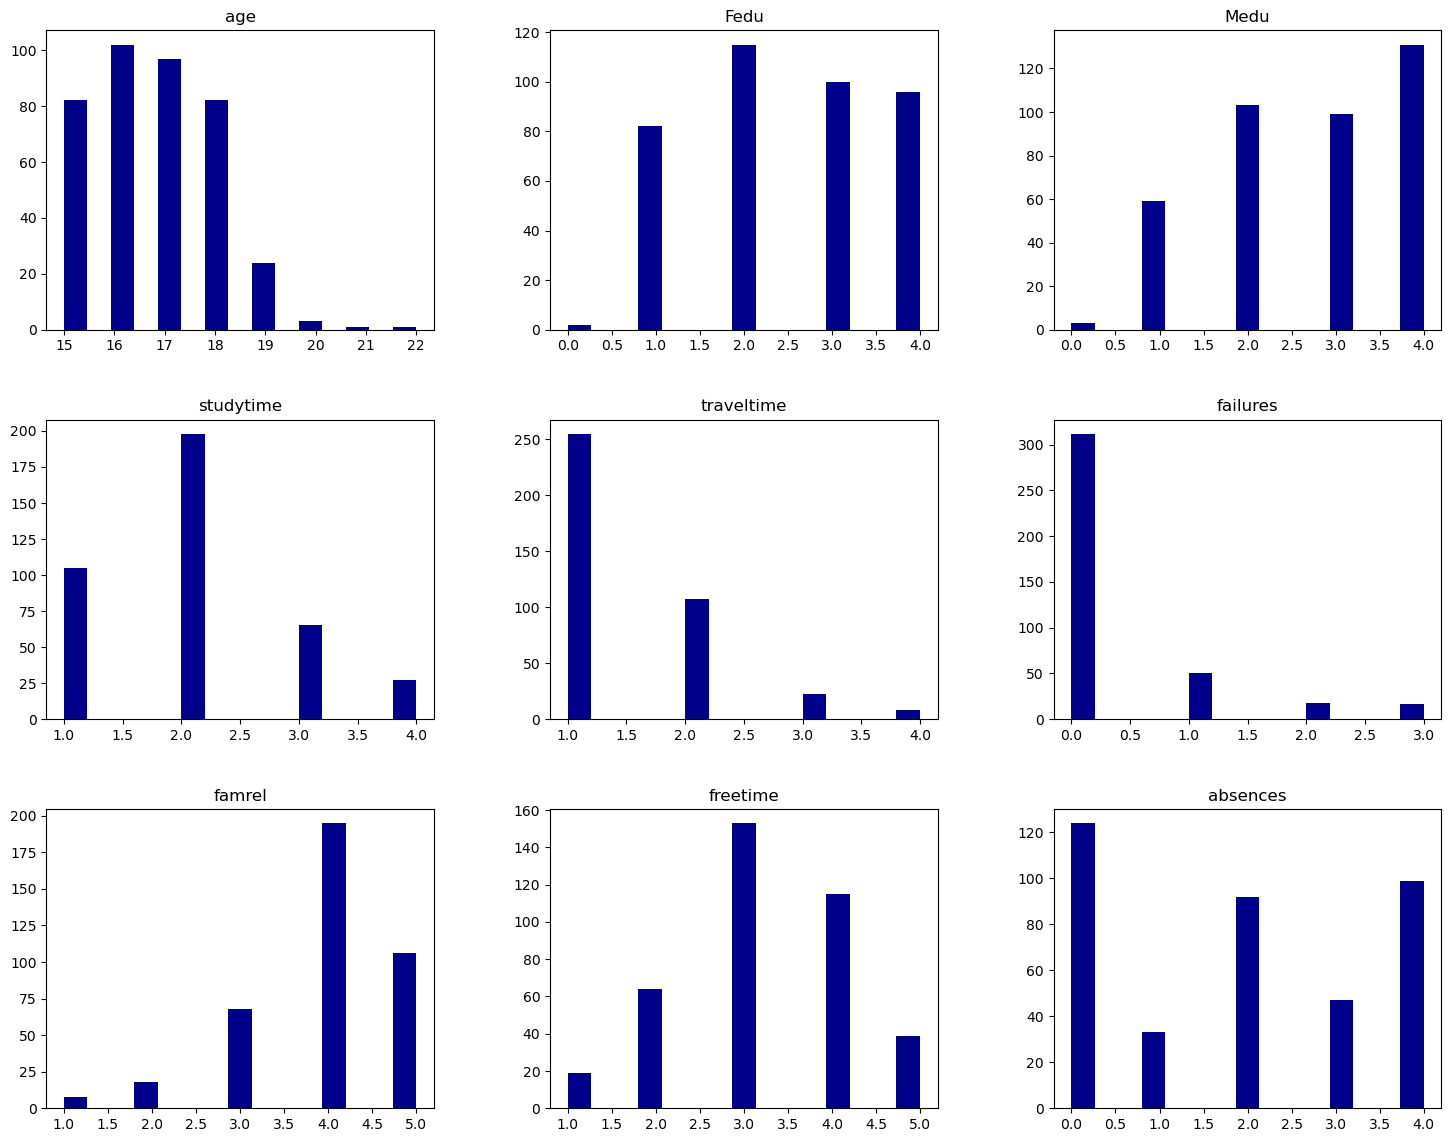

In [8]:
df.hist(bins=15, color='darkblue', figsize=(18,14), grid=False)
plt.show()

#### 원래 시험에서는 종속변수인 absences에 클래스 불균형이 있었다고 함. 추후 오버샘플링 방법 고려 
- 만든 데이터임을 감안

### 이상치 탐색

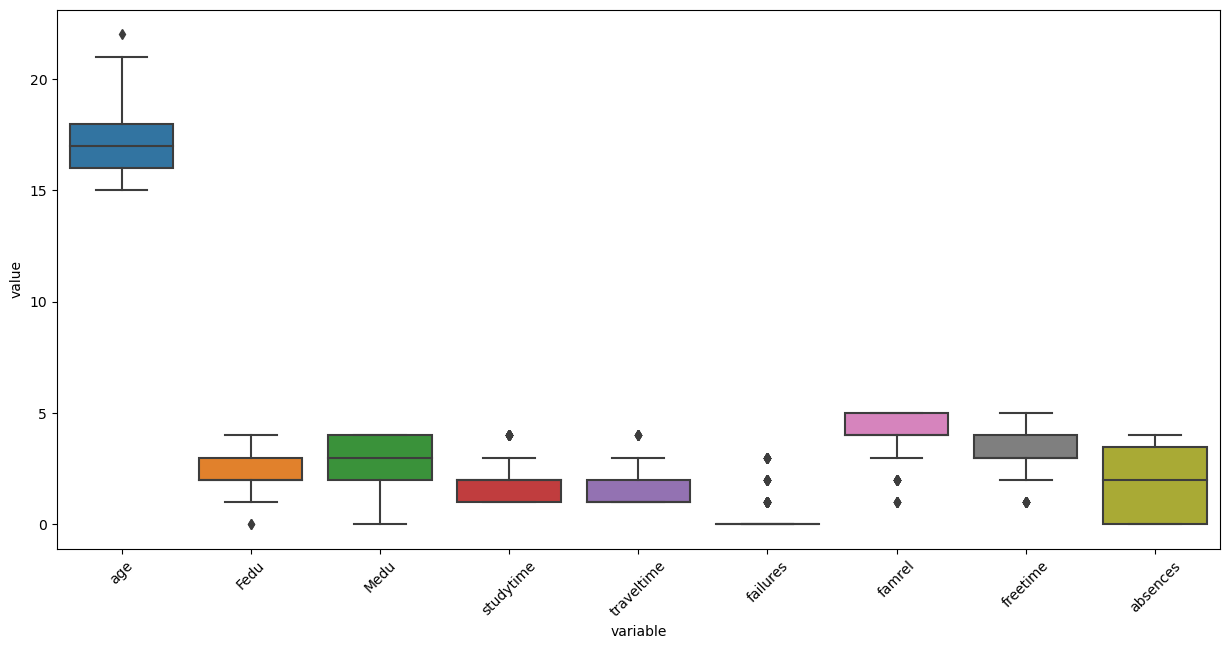

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 두 줄로 쉽게 끝내는 방법
# df.boxplot(figsize=(18,10))
# plt.show()


# boxplot을 그리기 위해 범주형 변수 제거 후 수치형 변수 columns 활용 
continuous_vars = df.select_dtypes(include=['int64', 'float64']).columns

X = df[continuous_vars]
df_v1 = pd.melt(X ,var_name='variable', value_name='value')

plt.figure(figsize = (15, 7))
sns.boxplot(x='variable', y='value', data=df_v1)
plt.xticks(range(len(X.columns)), X.columns, rotation=45)
plt.show()

### 범주형 변수 시각화

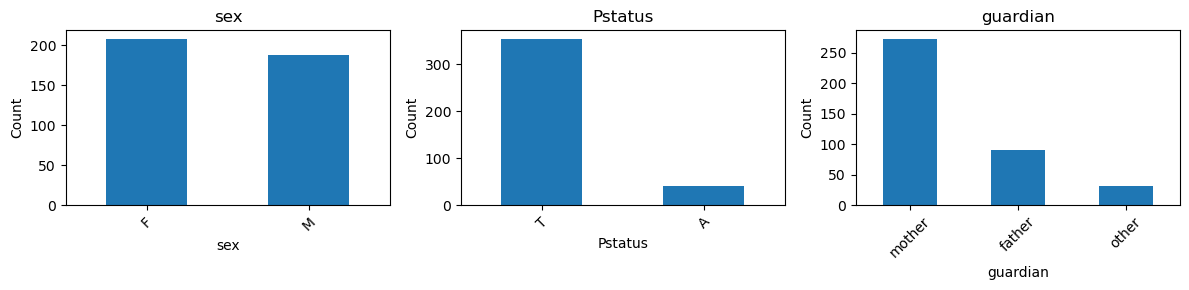

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임에서 범주형 변수 선택
categorical_vars = df.select_dtypes(include=['object']).columns

# 범주형 변수에 대한 barplot 그리기
fig, axes = plt.subplots(1, len(categorical_vars), figsize=(12, 3))

for i, var in enumerate(categorical_vars):
    ax = axes[i]
    df[var].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # 라벨들의 각도 조절

plt.tight_layout()
plt.show()

### 상관관계 시각화

<AxesSubplot:>

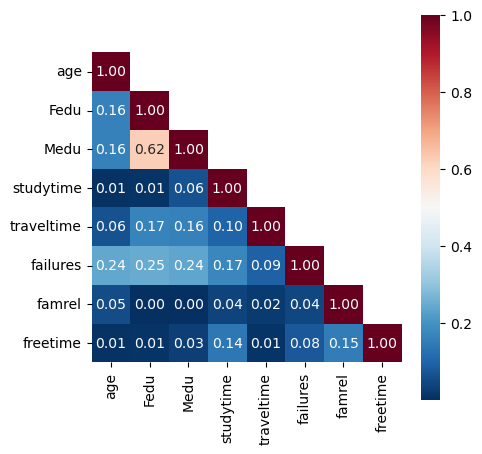

In [11]:
# 상관관계 시각화 : 히트맵
plt.figure(figsize=(5, 5))

# corr matrix 생성
corr_matrix = df.drop(['absences'], axis=1).corr().abs() # .abs() 절댓값 기준

# 상삼각행렬 반환
up_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)

sns.heatmap(corr_matrix, mask=up_mask, annot=True, 
            fmt='.2f', square=True, cmap='RdBu_r')

- 히트맵 시각화 결과, 변수 간 상관관계가 다소 높아보이는 경우가 존재하지 않는다고 파악하였다.
- 변수 간 상관관계가 높다면 다중공선성이 발생해 예측 성능에 문제를 일으킬 수 있으므로, 추후 차원축소나 변수 선택법 등의 방법을 고려해야한다. 
- 하지만 본 데이터에서는 다중공선성의 문제가 우려되지 않는다고 생각하였다.
- 또한 변수들이 명확한 의미를 가지고 있고 모델의 해석이 중요한 경우라고 생각하여, 차원축소 시 변수들의 해석 가능성이 저하될 다른 문제가 발생할 수 있어 차원축소에는 신중한 판단이 필요하다.

## 1-2) 1-1에서 찾은 문제 파악후 처리하기

### 결측치 처리
- 위에서 결측치 확인 결과, age, traveltime, freetime 변수에 각각 3, 3, 5개의 결측치가 있었으므로 결측치를 처리해준다.
- 결측값을 평균으로 대체 시 이상치의 영향을 받아 데이터가 왜곡될 수 있으므로 median으로 대체하는 방법을 고려한다.

In [12]:
# 결측치를 중앙값으로 대체
df['age'] = df['age'].fillna(df['age'].median()) 
df['traveltime'] = df['traveltime'].fillna(df['traveltime'].median()) 
df['freetime'] = df['freetime'].fillna(df['freetime'].median()) 

print(df.isnull().sum())

sex           0
age           0
Pstatus       0
Fedu          0
Medu          0
guardian      0
studytime     0
traveltime    0
failures      0
famrel        0
freetime      0
absences      0
dtype: int64


### 범주형 변수 인코딩
- 변수들은 모델에 직접적으로 입력될 수 없으므로, 숫자 형태로 변환해주기 위해 인코딩 해준다.

In [13]:
# 더미코딩
df = pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              395 non-null    float64
 1   Fedu             395 non-null    int64  
 2   Medu             395 non-null    int64  
 3   studytime        395 non-null    int64  
 4   traveltime       395 non-null    float64
 5   failures         395 non-null    int64  
 6   famrel           395 non-null    int64  
 7   freetime         395 non-null    float64
 8   absences         395 non-null    int64  
 9   sex_M            395 non-null    uint8  
 10  Pstatus_T        395 non-null    uint8  
 11  guardian_mother  395 non-null    uint8  
 12  guardian_other   395 non-null    uint8  
dtypes: float64(3), int64(6), uint8(4)
memory usage: 29.4 KB


### 연속형 변수 스케일링

In [14]:
# 피쳐와 종속변수 할당
X = df.drop(['absences'], axis=1)
y = df['absences']
display(X.head(3))

,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,sex_M,Pstatus_T,guardian_mother,guardian_other
0,18.0,4,4,2,2.0,0,4,3.0,0,0,1,0
1,17.0,1,1,2,1.0,0,5,3.0,0,1,0,0
2,15.0,1,1,2,1.0,3,4,3.0,0,1,1,0


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns=X.columns)
df_scaled

,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,sex_M,Pstatus_T,guardian_mother,guardian_other
0,1.019705,1.360371,1.143856,-0.042286,0.804185,-0.449944,0.062194,-0.231841,-0.948176,-2.938392,0.668496,-0.296908
1,0.234552,-1.399970,-1.600009,-0.042286,-0.639692,-0.449944,1.178860,-0.231841,-0.948176,0.340322,-1.495896,-0.296908
2,-1.335754,-1.399970,-1.600009,-0.042286,-0.639692,3.589323,0.062194,-0.231841,-0.948176,0.340322,0.668496,-0.296908
3,-1.335754,-0.479857,1.143856,1.150779,-0.639692,-0.449944,-1.054472,-1.238185,-0.948176,0.340322,0.668496,-0.296908
4,0.234552,0.440257,0.229234,-0.042286,-0.639692,-0.449944,0.062194,-0.231841,-0.948176,0.340322,-1.495896,-0.296908
...,...,...,...,...,...,...,...,...,...,...,...,...
390,2.590012,-0.479857,-0.685387,-0.042286,-0.639692,2.242901,1.178860,1.780847,1.054656,-2.938392,-1.495896,3.368048
391,0.234552,-1.399970,0.229234,-1.235351,0.804185,-0.449944,-2.171138,0.774503,1.054656,0.340322,0.668496,-0.296908
392,3.375165,-1.399970,-1.600009,-1.235351,-0.639692,3.589323,1.178860,1.780847,1.054656,0.340322,-1.495896,3.368048
393,1.019705,-0.479857,0.229234,-1.235351,2.248062,-0.449944,0.062194,0.774503,1.054656,0.340322,0.668496,-0.296908


## 1-3) 과적합 문제가 있다고 가정하고 해결하는 방법 2가지 이상 제시/실행/결과

### 오버샘플링 - SMOTE
- 종속변수 클래스 불균형 문제가 존재할 시, 분류 모델 성능 중 Accuracy에 초점을 두게 된다면 과적합의 위험이 존재할 수 있다. (실제 시험에서 어떤 범주는 value counts가 3밖에 안되는 심한 imbalances 데이터였다고 함)
- 따라서 이를 해결하기 위해, 언더샘플링 혹은 오버 샘플링 방법으로 데이터 분포를 맞춰줘야한다. 
    - 하지만 언더샘플링의 경우 데이터가 적은 갯수에 맞춰 샘플링이 된다면 데이터 손실이 크기 때문에 오버샘플링 방법이 필요하다고 판단했다. 그 중 과적합을 방지하는 'SMOTE' 방법을 고려하는것이 적절할 것으로 보인다.
    
(오버샘플링 2가지 방법- 랜덤오버샘플링, SMOTE 시각화로 비교해도 괜찮을 것 같음. 27회, 23회, 22회 참고)

In [16]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_scaled, 
                                                    y,                                                     
                                                    random_state=23,
                                                    test_size=0.2)

In [17]:
X_train.shape, X_test.shape

((316, 12), (79, 12))

In [18]:
print('Original Data')
print(y_train.value_counts()) 

Original Data
0    95
4    77
2    71
3    42
1    31
Name: absences, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTE

# SMOTE
X_SMO, y_SMO = SMOTE(random_state=2023).fit_resample(X_train, y_train)
print('After SMOTE')
print(y_SMO.value_counts())

After SMOTE
2    95
4    95
0    95
3    95
1    95
Name: absences, dtype: int64


### 교차검증(cross validation)
- 한정된 데이터 셋으로만 모델 학습을 하는 경우 오버피팅 발생
    - 학습, 테스트 데이터 분리 시, 나뉘어진 기준으로만 학습이 잘 될 수 있기 때문에 cross validation을 수행한다. 
    * cross validation은 k-fold 으로 수행
   
        * 전체 데이터 셋을 train, test 셋으로 나누고
        * train set을 train+validation 으로 사용하기 위해 k개의 폴드로 나눈다.
        * 첫 번째 폴드를 validation으로 사용하고 나머지 폴드들을 training set으로 사용한다.
        * 모델을 training 한 뒤, 첫 번째 validation set으로 평가한다.
        * 차례대로 다음 폴드를 validation set으로 사용하면 3-4번 반복한다.
        * 총 k개의 성능 결과를 평균으로 한 것을 학습 모델 성능이라 한다.

In [20]:
# 교차검증 전 rf 모델 수행
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# 평가 지표
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# f1_score(train_y, rf.predict(train_X), average='micro')

from sklearn.metrics import accuracy_score # 정확도

# accuracy_score(train_y, rf.predict(train_X))
scoring = make_scorer(f1_score, average = 'macro')

In [22]:
# CV 수행 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = scoring)

print("f1 score of each fold:", [f'{acc:.3f}' for acc in scores])
print(f"f1 : {scores.mean():.3f}")

f1 score of each fold: ['0.233', '0.192', '0.168', '0.199', '0.151']
f1 : 0.189


### 오버샘플링 적용 후 교차 검증

In [23]:
# CV 수행 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_SMO, y_SMO, cv=5, scoring = scoring)

print("f1 score of each fold:", [f'{acc:.3f}' for acc in scores])
print(f"f1 : {scores.mean():.3f}")

f1 score of each fold: ['0.328', '0.384', '0.557', '0.492', '0.735']
f1 : 0.499


#### 오버샘플링을 적용 후 교차검증한 결과, 성능이 전반적으로 조금 더 좋아진 것을 확인할 수 있다.

## 2-1) 랜덤포레스트, 인공신경망(neuralnetwork), LightGBM 모델링 수행 후 f1-score 비교

클래스가 3개 이상인 다중분류(Multi-class)인 경우
```python
# f1_score의 average 옵션 이용
sklearn.metrics.f1_score(y_true, y_pred, average="macro") 
```

- f1-score은 0과 1 사이의 값을 가지며, 높을수록 분류 모델의 성능이 좋다고 판단
- f1-score이 1에 가까울수록 모델이 정확하게 클래스를 분류하고 있으며, 정밀도와 재현율이 모두 높은 수준으로 유지되고 있는 것을 의미

</br>

- Macro Average F1 Score : 클래스별 F1 Score를 평균
    -  Macro F1 점수는 모든 클래스에 대한 성능을 고려하기 때문에, 클래스 불균형이 심한 경우에도 공평한 평가를 제공
- Micro Average F1 Score : 클래스별 accuracy = micro-recall
    - 클래스별로 분리된 접근이 아니라 전체 데이터셋 수준에서 계산
- Weighted Average F1 Score : 클래스별 F1 Score * Support 비율

In [24]:
# # 추가 공부 : 그리드 서치
# 위에서 교차검증 진행했으니, 시험장에선 시간 효율따져서 굳이 실행 X ..

# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt'],
# }

In [25]:
import os
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm

from sklearn.metrics import f1_score

### 1) 랜덤포레스트

In [26]:
start = time.time()

rf = RandomForestClassifier()
rf.fit(X_SMO, y_SMO)
print("RF model f1-score:",
      np.round(f1_score(y_test, rf.predict(X_test), average='macro'), 3))

end = time.time()
print("모델 수행시간 : {:.3f}초".format(end-start))

RF model f1-score: 0.19
모델 수행시간 : 0.211초


In [27]:
# # 추가 : Grid Search 수행
# rf_grid = GridSearchCV(estimator=rf, 
#                            param_grid=param_grid, 
#                            cv=5, 
#                            n_jobs=-1, 
#                            verbose=2,
#                            scoring=scoring
#                           )
# rf_grid.fit(X_SMO, y_SMO)
# print("best param:\n", rf_grid.best_params_)



# # rf_grid.best_estimator_
# rf_pred =  rf_grid.best_estimator_.predict(test_X)
# print("RF model f1-score:", np.round( f1_score(test_y, 
#                                                rf_pred,
#                                                average='macro'),3))

### 2) 인공신경망

In [28]:
# mlp_params= {
#    'hidden_layer_sizes': [100, 150, 200],
#    'solver': ['lbfgs', 'sgd', 'adam'],
#   #  'momentum': np.arange(0.1,1.1,0.1),
#   #  'learning_rate': [0.001, 0.01]
#         }

In [29]:
start = time.time()

mlp = MLPClassifier()
mlp.fit(X_SMO, y_SMO)
print("MLP model f1-score:", 
      np.round(f1_score(y_test, mlp.predict(X_test), average='macro'), 3))

end = time.time()
print("모델 수행시간 : {:.3f}초".format(end-start))

MLP model f1-score: 0.21
모델 수행시간 : 0.887초


In [30]:
# # Grid Search 수행
# mlp_grid = GridSearchCV(estimator=mlp, 
#                            param_grid=mlp_params, 
#                            cv=5, 
#                            n_jobs=-1, 
#                            verbose=2,
#                            scoring=scoring
#                           )
# mlp_grid.fit(train_X_over, train_y_over)
# print("best param:\n", mlp_grid.best_params_)


# # mlp.best_estimator_
# print("MLP model f1-score:", np.round( f1_score(test_y, 
#                                                mlp_grid.best_estimator_.predict(test_X),
#                                                 average='macro'),3))

### 3) LGBM

In [31]:
start = time.time()

lgbm = lightgbm.LGBMClassifier()
lgbm.fit(X_SMO, y_SMO)
print("LGBM model f1-score:",
      np.round(f1_score(y_test, lgbm.predict(X_test), average='macro'), 3))

end = time.time()
print("모델 수행시간 : {:.3f}초".format(end-start))

LGBM model f1-score: 0.172
모델 수행시간 : 0.460초


#### MLP model f1-score: 0.214로 세 모델 중 가장 f1 score가 높음을 확인할 수 있다.

### 추가 공부 : catboost 
- Boosting 계열의 앙상블 알고리즘
- **범주형 변수(Categorical Variable)가 많을 때 사용** (회귀, 분류 모두 가능)
</br>

-  알고리즘 이해  
    - 기존의 부스팅 모델이 일괄적으로 모든 훈련 데이터를 대상으로 잔차계산을 했다면, CatBoost는 일부의 데이터만 가지고 
         잔차계산을 한 뒤, 이 데이터로 모델을 만들고 그 다음의 데이터의 잔차는 이 모델로 예측한 값을 사용한다.  
    - CatBoost는 시계열이 포함되어 있지 않은 일반적인 비시계열 데이터라도 CatBoost가 임의적으로 시계열을 형성해 Boosting 진행  
    - 아래는 10개의 데이터 밖에 없지만, 10만개의 경우 10만개의 모델을 학습 시키기에 연산속도가 느려질 것이다. 그래서 CatBoost는 이전 설명처럼 일부 데이터만 가지고 학습해, 속도를 개선 시킨 것 ( 그래서 log(데이터갯수) 만큼 데이터 추출 )
    
</br>

- 장점
    - Xgboost, LightGBM 의 다른 Boosting 계열 알고리즘 보다 학습 속도가 개선되었다.
    - 기존의 Boosting 계열의 알고리즘보다 오버피팅을 개선 시켰다.
    - 데이터 셋을 명확하게 구분할 수 있는 중복되는 변수가 2개 이상 존재할 때, 이를 하나의 변수로 통합해 처리해서 Feature가 줄어
    들어 학습 속도 개선됨 (아래 2개 feature는 똑같아서 둘 다 필요 없음)
    
</br>

- 단점
     - 데이터 대부분이 수치형 변수인 경우, Light GBM 보다 학습 속도가 느리다. (범주형 변수가 많을 때 사용 하라는 뜻)
     - 결측치가 매우 많은 데이터에는 부적합하다.

Catboost 옵션 상세 내용

- cat_features=cat_features 옵션
    - 현재 이 데이터는 범주형 변수이긴 하나 모두 수치형으로 되어 있어서 cat_feature라는 파라미터를 사용하지 않아도 되지만
    - 만약 범주형 변수가 있으면 해당 컬럼 이름 또는 컬럼의 인덱스를 리스트 형태로 적어주면 된다.
- loss_function='MultiClass
    -  손실함수로써 해당 손실함수가 계속 작아지도록 학습하는 것임
    - target의 범주가 3개 이상일 때 : MultiClass
    - 2개 이하 일때 : 'Logloss' 써주면 됨 
- eval_metric='AUC'
    - 평가척도로 AUC 사용: 원래 다중클래스에서는 AUC보다 F1-Score Macro가 좀 더 적절 
    - (중요) 만일 target의 class 불균형이 심하다면 무조건 F1-Score 를 사용하고 class 갯수가 3개 이상이라면 F1-Score Macro를 사용
    - 그런데 우선 Catboost에서 F1-Score Macro가 없고 현재 데이터는 target의 불균형이 심하질 않다.

In [32]:
from catboost import CatBoostClassifier

In [33]:
# Catboost 모델
start = time.time()
clf_catb = CatBoostClassifier(# cat_features=cat_features
                             n_estimators = 100,          # tree 생성 갯수
                             max_depth = 10,              # tree 깊이
                             learning_rate = 0.01,        # 학습률
                             loss_function='MultiClass',  
                             eval_metric='AUC',                                                                  
                             random_state=2023,
                             verbose=False)
clf_catb.fit(X_SMO, y_SMO)

print("Catboost model f1-score:", 
      np.round( f1_score(y_test, clf_catb.predict(X_test),average='macro'),3))

end = time.time()
print("모델 수행시간 : {:.3f}초".format(end-start))

Catboost model f1-score: 0.119
모델 수행시간 : 5.080초


## 2-2) Soft-voting, Hard-voting 수행 후 f1-score 비교

- 앙상블 모델의 예측값을 결정짓기 위해 weak learner의 예측값을 바탕으로 voting
- 보팅은 일반적으로 서로 다르 알고리즘을 가진 분류기를 결합

### hard voting (직접 투표) : 각 모델의 예측값을 바탕으로 다수결 투표
- 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것

### soft voting (간접 투표) : 각 모델의 예측값들의 평균 또는 가중치 합을 사용하는 방식
- **모든 분류기가 클래스의 확률을 예측**할 수 있으면(즉, predict_proba() 메서드가 있으면), 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측
- 분류기들의 레이블 값 결정 확률을 모두 더하고, 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정
- 일반적으로 하드 보팅보다는 소프트 보팅이 예측 성능이 좋아서 더 많이 사용됨
</br>

- predict_proba() 메서드를 제공하는 분류기 : 확률 기반의 예측을 수행
    - 로지스틱 회귀 (Logistic Regression)
    - 나이브 베이즈 (Naive Bayes)
    - 서포트 벡터 머신 (Support Vector Machines)의 일부 구현
    - K-최근접 이웃 (K-Nearest Neighbors)의 일부 구현
    - 의사결정나무 (Decision Trees)의 앙상블 모델인 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting) 기반의 모델들 (예: XGBoost, LightGBM, CatBoost)

</br>

- 반면에 predict_proba() 메서드를 제공하지 않는 분류기들은 클래스에 대한 확률 분포를 직접적으로 제공하지 않음
    - 의사결정나무 (Decision Trees)의 단일 트리 구현
    - 서포트 벡터 머신 (Support Vector Machines)의 일부 구현
    - 신경망 (Neural Networks)의 일부 구현


In [34]:
from sklearn.ensemble import VotingClassifier

# 소프트 보팅
soft_voting = VotingClassifier(voting='soft',
                               estimators=[('rf', rf), ('mlp', mlp), ('lgbm', lgbm)])
soft_voting.fit(X_SMO, y_SMO)
print("Soft Voting model f1-score:",
      np.round(f1_score(y_test, soft_voting.predict(X_test), average='macro'), 3))



# 하드 보팅
hard_voting = VotingClassifier(voting='hard',
                               estimators=[('rf', rf),('mlp', mlp),('lgbm', lgbm)])
hard_voting.fit(X_SMO, y_SMO)
print("Hard Voting model f1-score:",
      np.round(f1_score(y_test, hard_voting.predict(X_test),average='macro'),3))

Soft Voting model f1-score: 0.191
Hard Voting model f1-score: 0.177


## 2-3) 5가지 방법 중 최적의 방법 선택 및 이유 설명

* RF model f1-score: 0.19
* MLP model f1-score: 0.21
* LightGBM model f1-score: 0.172
* Soft Voting model f1-score: 0.191
* Hard Voting model f1-score: 0.177

MLP 모델이 f1-score 0.21로 가장 높기 때문에, 최적의 모델로 선택한다.

</br>

소희님 답변 참고
* RF model f1-score: 0.671
* MLP model f1-score: 0.668
* LightGBM model f1-score: 0.699
* Soft Voting model f1-score: 0.686
* Hard Voting model f1-score: 0.699

* 선택: LightGBM
    * 위의 결과 기준으로 Soft, Hard voting은 3가지 모델의 결과를 고려하였음에도 불구하고 LGBM모델과 성능이 비슷
    * LightGBM model이 위의 soft, hard voting 방법보다 연산량이 적을 것이므로 Voting 방법 탈락
    * MLP보다 트리계열 모델인 RandomForest와 LGBM이 시각화나 feature importance를 볼 수 있어서 더욱 설명력이 좋음
    * RF vs LGBM : 배깅 모델과 부스팅 모델의 차이가 있지만. 이 데이터의 경우 class imbalance 문제가 있기에 이에 대한 적절한 지표인 f1-score가 높은 LightGBM 선정 


## 2-4) 만든 모델을 학교 정보시스템에서 활용하려면 어떻게 해야하는지 적고 설명
- 계속 새 데이터 들어오니 가중치 업데이트 해야 한다.
- 유저에게 신속한 예측결과 제공 위해 시간효율성으로 적극적으로 고려해야 한다
- 데이터 쌓이면 과적합 방지 위해서 모델 조금 경량화 해도 괜찮다 등등...

</br>

- 1) 데이터 갱신/ 모델 배치 주기 / 모델 재학습 기간 설정 
    - ex. 금주 학생의 결석 예측 시스템 결과를 보기 위해 모델을 일주일 마다, 매주 일요일에 실행
    - 데이터베이스에 부하가 없는 시간대에 돌 수 있도록 스케쥴링 시간 설정
    - 데이터의 변화나 환경의 변화에 따라 모델을 조정하고 유지 보수하는 것 중요
    - 모델이 활용되는 동안 예측 성능을 모니터링하고, 필요한 경우 모델을 업데이트하여 정확도를 개선할 수 있도록 한다.
- 2) API 생성
    - 모델 결과를 Interface 할 수 있는 API를 개발한다. EX) python Flask, FAST API 등
- 3) 개인정보 마스킹 처리
    - 학생 개인에 대한 정보이기에 이름 등 개인정보를 마스킹 처리하여 모델 생성할 수 있도록 주의한다.

---

* 실제 시험에 나온 데이터를 kaggle에서 찾아 변형
    - kaggle : https://www.kaggle.com/datasets/dipam7/student-grade-prediction
* 그러나 아래 데이터의 컬럼수나 종속변수 분포가 변형되어 출제
    * 결석률 예측 -> 0~4
* PCA 및 모델 정확도가 심각하게.. 잘 나오지 않아 결과값보다는 문제 풀이 방법 위주로 참고 

Reference
- https://coding-law.tistory.com/68